In [1]:
%env NX_CUGRAPH_AUTOCONFIG=True
import networkx as nx
import numpy as np
import scipy as sp
from numpy.random import rand
import matplotlib.pyplot as plt
import time
import cProfile

env: NX_CUGRAPH_AUTOCONFIG=True


In [2]:
dense_grids = {}

In [3]:
dense_grids[100] = nx.grid_2d_graph(100,100)

In [4]:
def generate_percolation_graph(p,L):
    if L in dense_grids:
        G = dense_grids[L].copy()
    else:
        G = nx.grid_2d_graph(L,L)
        dense_grids[L] = G.copy()
    for edge in G.edges:
        if p < rand():
            G.remove_edge(edge[0],edge[1])
    return G


def avg_cluster_size(p,L, repititions=100):
    r"""
    For a square graph of L*L nodes, compute the average cluster size,
    excluding the largest cluster. As L->infinity, this ensures that this
    function diverges at the phase transition, but nowhere else.
    """
    counts = np.zeros(L**2+1,dtype=np.int64)
    for _ in range(repititions):
        G = generate_percolation_graph(p,L)
        comps = nx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=L**2+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(L**2+1))    
    return (bins**2 @ counts) / (bins@counts)

def percolation_strength(p,L,repititions=100):
    r"""
    For a square graph of L*L nodes, compute the percolation strength,
    which is the proportion of the graph belonging to the largest cluster,
    which should be the order paramater of the phase tranistion as L->infinity
    """
    P = 0
    for _ in range(repititions):
        G = generate_percolation_graph(p,L)
        comps = nx.connected_components(G)
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        P += largest_local / L**2
    return P/repititions

def cluster_size_and_strength(p,L,repititions=100):
    r"""
    return both the percolation strength and the average cluster size
    for the square L*L percolation graph as a tuple (size, strength)
    """
    counts = np.zeros(L**2+1,dtype=np.int64)
    P = 0
    for _ in range(repititions):
        G = generate_percolation_graph(p,L)
        comps = nx.connected_components(G)
        
        distro = [len(comp) for comp in comps]
        largest_local = np.max(distro)
        P += largest_local / L**2
        
        temp_counts = np.bincount([len(comp) for comp in comps],minlength=L**2+1)
        temp_counts[largest_local]=0
        counts += temp_counts
    bins = np.array(range(L**2+1))    
    return (bins**2 @ counts) / (bins @ counts), P
    

In [6]:
with cProfile.Profile() as pr:
    avg_cluster_size(.4,1000,repititions=50)
    pr.print_stats(sort=1)

         3296960584 function calls (3296959963 primitive calls) in 2060.859 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 11723992  668.587    0.000  686.740    0.000 {method 'tolist' of 'cupy._core.core._ndarray_base' objects}
      409  238.114    0.582 1263.552    3.089 selectors.py:451(select)
      409  167.589    0.410  310.695    0.760 {method 'poll' of 'select.epoll' objects}
       53  125.651    2.371  204.320    3.855 graph.py:975(add_edges_from)
    52/51  106.768    2.053  172.299    3.378 graph.py:573(add_nodes_from)
776275954   78.841    0.000   78.841    0.000 graph.py:141(_adj)
504596156   69.352    0.000   69.352    0.000 {method 'update' of 'dict' objects}
199800050   68.163    0.000   99.409    0.000 graph.py:1663(<genexpr>)
606596050   63.010    0.000   64.700    0.000 graph.py:126(_node)
       50   62.780    1.256   63.861    1.277 misc.py:63(_groupby)
       50   58.915    1.178  649.247   12.985 

/tmp/ipykernel_216889/463699796.py:29: RuntimeWarning: invalid value encountered in scalar divide
  return (bins**2 @ counts) / (bins@counts)


In [ ]:
pvals = np.arange(.35,.6,.01)

reps=100
density = {}
strength = {}
Lvals = [50,60,70,80,90,100]

for L in Lvals:
    start = time.time()
    density[L] = [avg_cluster_size(p,L,repititions=reps) for p in pvals]
    strength[L] = [percolation_strength(p,L,repititions=reps) for p in pvals]
    end = time.time()
    print(f"Avg Computation time per graph for L={L} is {(end-start)/(reps*len(pvals))} s")

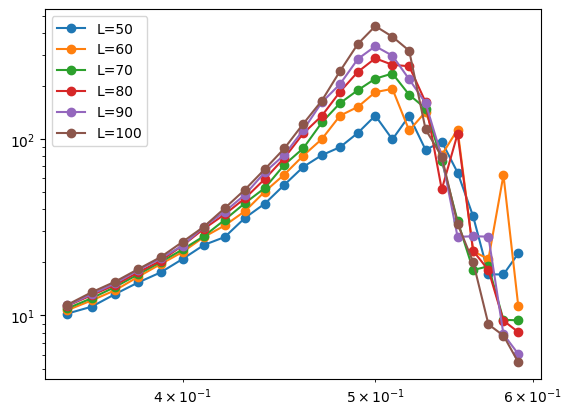

In [5]:
for L in Lvals:
    plt.loglog(pvals,density[L],label=f"L={L}",marker='o')
plt.legend()
plt.show()

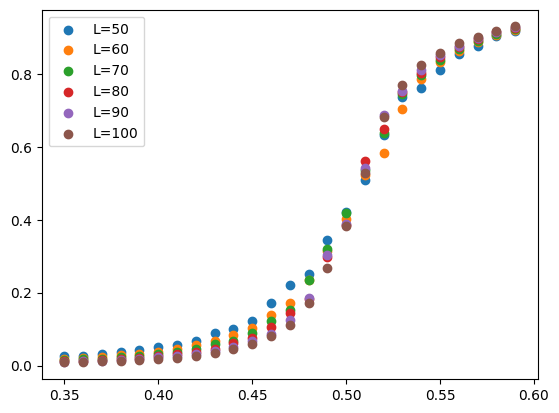

In [6]:
for L in Lvals:
    plt.scatter(pvals,strength[L],label=f"L={L}")
plt.legend()
plt.show()

In [8]:
reps=50
L=100
start = time.time()
for _ in range(reps):
    G = nx.grid_2d_graph(L,L)
end = time.time()
print((end-start)/reps)

0.04054922103881836
